<a href="https://colab.research.google.com/github/DennisChangach/getting_started_with_NLP/blob/main/Stock_Prediction_and_Forecasting_Using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction and Forecasting Using Stacked LSTM

In [12]:
import pandas_datareader as pdr
import pandas as pd

In [7]:
from google.colab import userdata
key = userdata.get('TIINGO_API_KEY')

In [13]:
#Getting the data
#df = pdr.get_data_tiingo('AAPL',api_key=key)
df = pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [14]:
df1=df.reset_index()['close']

In [15]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

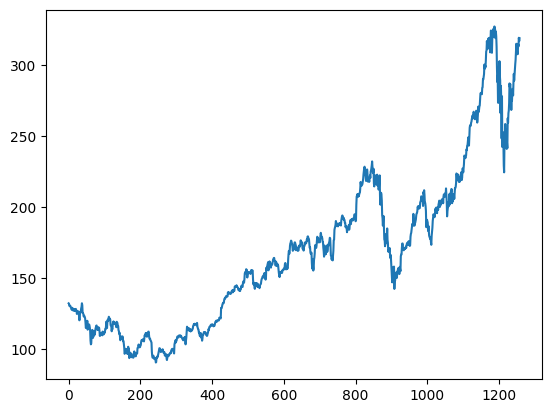

In [16]:
import matplotlib.pyplot as plt
plt.plot(df1)

Note: LSTM is sensitive of scale of the data hence data transformation is key.

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#Scale between 0-1
scaler = MinMaxScaler(feature_range=(0,1))
#Reshape the array
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

## Train Test Split
For Time Series Data - You cannot do a random split. The split has to be done chronologically.

In [19]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [20]:
train_data.shape,test_data.shape

((817, 1), (441, 1))

In [21]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [23]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [24]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [25]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [26]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [27]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 276ms/step - loss: 0.0207 - val_loss: 0.0504
Epoch 2/100
12/12 [==============================] - 2s 197ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 3/100
12/12 [==============================] - 3s 247ms/step - loss: 9.3441e-04 - val_loss: 0.0099
Epoch 4/100
12/12 [==============================] - 2s 160ms/step - loss: 7.6338e-04 - val_loss: 0.0038
Epoch 5/100
12/12 [==============================] - 2s 158ms/step - loss: 6.3187e-04 - val_loss: 0.0038
Epoch 6/100
12/12 [==============================] - 2s 159ms/step - loss: 5.9029e-04 - val_loss: 0.0037
Epoch 7/100
12/12 [==============================] - 2s 161ms/step - loss: 5.9530e-04 - val_loss: 0.0038
Epoch 8/100
12/12 [==============================] - 2s 162ms/step - loss: 5.9960e-04 - val_loss: 0.0037
Epoch 9/100
12/12 [==============================] - 3s 263ms/step - loss: 5.7534e-04 - val_loss: 0.0035
Epoch 10/100
12/12 [==============================] - 2s 159ms/

In [30]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 37ms/step


In [31]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [32]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.71156411783036

In [33]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

239.24435035638953

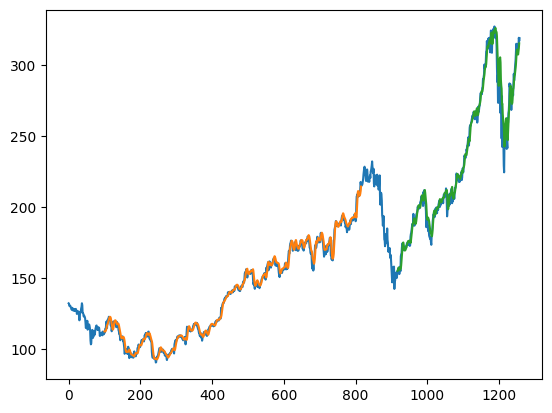

In [34]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Predicting the Next 30 Days

In [35]:
len(test_data)

441

In [36]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [39]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.9624233]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

In [41]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

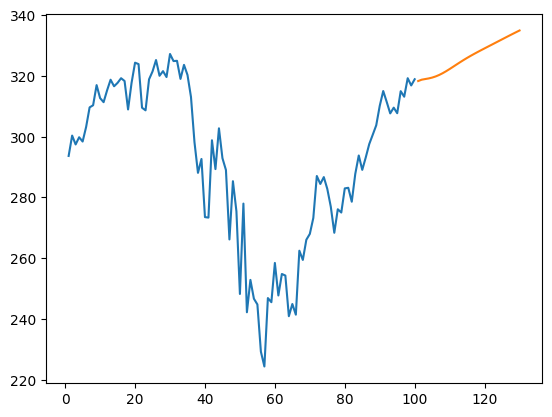

In [42]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

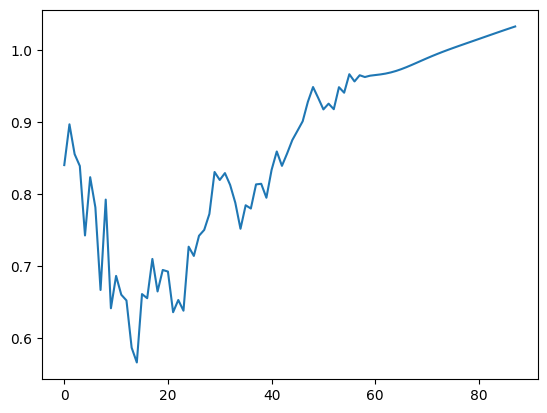

In [43]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])